In [300]:
import tweepy
import pandas as pd
from pandas.io.json import json_normalize #package for flattening json in pandas df
from config import consumer_key, consumer_secret, access_token, access_token_secret
import matplotlib.pyplot as plt
from datetime import datetime
import time
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
analyzer = SentimentIntensityAnalyzer() # Initialize the class 

In [284]:
# Twitter credentials
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [285]:
def get_df_for_user_tweets(username):
    try:
        target_tweets = []
        for status in tweepy.Cursor(api.user_timeline, id=username).items(nbr_tweets):
            target_tweets.append(status)
        temp_df = pd.DataFrame([ (x.user._json['screen_name'], x.text, x.created_at, analyzer.polarity_scores(x.text))
                                for x in target_tweets])
        temp_df.columns = ['user', 'tweet_text', 'created', 'sentiment']
        return temp_df
    except Exception as e:
        print(str(e), "Please debug this!")

In [286]:
def plot_sentiments(name, sentiments, nbr_tweets):
    now = datetime.now()
    #It's a bit tricky to reverse the x axis
    plt.stem(list(range(1-nbr_tweets,1)), list(reversed(sentiments[0:nbr_tweets])))
    plt.title(f"Sentiment Analysis of {name} Tweets ({now.month}/{now.day}/{now.year})")
    plt.xlabel('Tweets Ago')
    plt.ylabel('Tweet Polarity')
    plt.savefig(str(name))
    plt.show()

## PlotBot

In [287]:
import snowflake
import calendar
import time
from tqdm import tqdm

In [288]:
nbr_tweets = 500

In [289]:
def push_status_from_local_media(filename, status):
    try:
        api.update_with_media(filename, status=status)
    except Exception as e:
        print(str(e))

In [295]:
utc_now = calendar.timegm(datetime.utcnow().timetuple())
retro_interval = 15*60 # The bot will find tweets no older than this many seconds old
max_tweet_id = snowflake.utc2snowflake(utc_now - retro_interval)

No requests found


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [05:00<00:00,  5.00s/it]


Found a new tweet


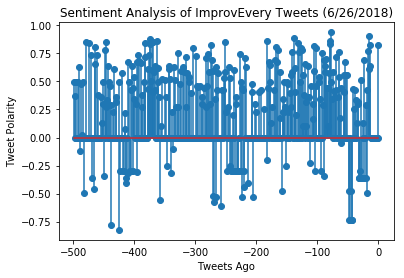

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [05:00<00:00,  5.00s/it]


Found a new tweet


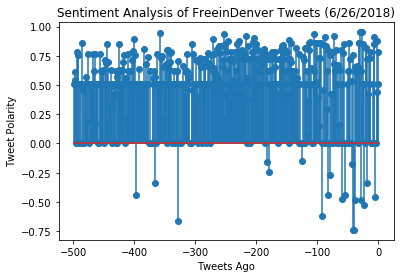

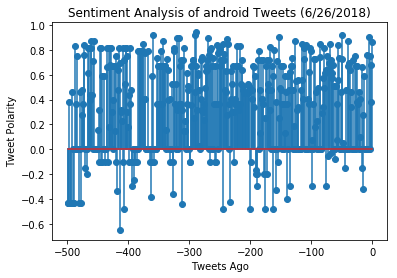

 13%|███████████                                                                        | 8/60 [00:40<04:20,  5.00s/it]

KeyboardInterrupt: 

In [302]:
# Scan my account for mentions
target = '@Bot6Plot'
analyzed = []
# max_tweet_id = None

while True:
    target_tweets = []
    
    for status in tweepy.Cursor(api.search,
        target, result_type="recent", since_id=max_tweet_id).items(10):
        target_tweets.append((status.text, status.id, status.user.screen_name, status.created_at))

    if target_tweets:
        temp_max_tweet_id = target_tweets[0][1]
        if temp_max_tweet_id != max_tweet_id:
            print('Found a new tweet')
            for tweet in target_tweets:
                BotPlotCommand = tweet[0].split('"')
                if (len(BotPlotCommand) > 1):
                    name = BotPlotCommand[1]
                    handle = '@' + name
                    # It's a bit tricky to decide when to use name versus handle
                    # The main purpose of name is to avoid putting the @ symbol in the filename
                    if not name in analyzed:
                        tweets_df = get_df_for_user_tweets(handle)
                        if (len(tweets_df) > 0):
                            plot_sentiments(name, [x['compound'] for x in tweets_df['sentiment']], nbr_tweets)
                            push_status_from_local_media(name + '.png', f"New Tweet Analysis: @{name}  (Thx @{tweet[2]}!!)")
                            analyzed.append(name)
                        else:
                            print ("No tweets found for " + handle)
            max_tweet_id = temp_max_tweet_id
    else:
        print ("No requests found")
#    break
    for i in tqdm(range(60)):
        time.sleep (5)
    